In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,sklearn,pd,keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.2.0
numpy 1.18.1
sklearn 0.22.2.post1
pandas 1.0.1
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


# 1. 加载数据 #

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all,Y_train_all),(X_test,Y_test) = fashion_mnist.load_data()

In [3]:
X_train,Y_train = X_train_all[5000:],Y_train_all[5000:]
X_valid,Y_valid = X_train_all[:5000],Y_train_all[:5000]
print("train set:",X_train.shape,Y_train.shape)
print('valid set:',X_valid.shape,Y_valid.shape)
print('test set:',X_test.shape,Y_test.shape)

train set: (55000, 28, 28) (55000,)
valid set: (5000, 28, 28) (5000,)
test set: (10000, 28, 28) (10000,)


# 2. 显示数据 #

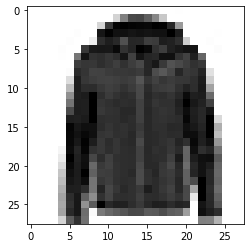

In [4]:
def show_single_image(arr):
    plt.imshow(arr,cmap='binary')
    plt.show();
    
show_single_image(X_train[0])

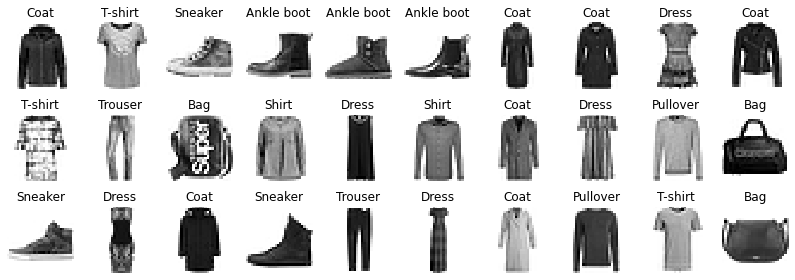

In [5]:
def show_images(n_rows,n_cols,x_data,y_data,classes):
    assert len(x_data) == len(y_data)
    assert n_cols * n_rows <= len(x_data)

    fig = plt.figure(figsize=(n_cols * 1.4,n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            ax = fig.add_subplot(n_rows,n_cols,i+1,title=classes[y_data[i]])
            ax.imshow(x_data[i],cmap='binary',interpolation='nearest')
            ax.axis('off')
    plt.show()    

class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

show_images(3,10,X_train,Y_train,class_names)

In [6]:
# 归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train.astype('float32').reshape(-1,1)).reshape(-1,28,28)
X_valid_scaler = scaler.transform(X_valid.astype('float32').reshape(-1,1)).reshape(-1,28,28)
X_test_scaler = scaler.transform(X_test.astype('float32').reshape(-1,1)).reshape(-1,28,28)

# 3. 定义模型 #

## 3.1 定义模型 ##

In [7]:
# 把激活函数放在批归一化之前
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
model.add(keras.layers.Dense(10,activation='softmax'))

In [14]:
# 把激活函数放在批归一化之后
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
model.add(keras.layers.Dense(10,activation='softmax'))

## 3.2 编译模型 ##

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

## 3.3 训练模型 ##

In [16]:
logdir = './dnn-callbacks' # 每个引用定义自己的log目录，防止应用之间互相污染
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_file = os.path.join(logdir,'fashion_mnist_model.h5')

In [17]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(output_file,save_best_only=True),
    keras.callbacks.EarlyStopping(min_delta=1e-3,patience=5)
]
history = model.fit(X_train_scaler,Y_train,epochs=10,
                    validation_data=(X_valid_scaler,Y_valid),
                   callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 22s 396us/sample - loss: 1.0247 - accuracy: 0.6443 - val_loss: 0.6101 - val_accuracy: 0.7782
Epoch 2/10
55000/55000 [==============================] - 16s 290us/sample - loss: 0.6915 - accuracy: 0.7561 - val_loss: 0.5120 - val_accuracy: 0.8124
Epoch 3/10
55000/55000 [==============================] - 16s 295us/sample - loss: 0.5955 - accuracy: 0.7896 - val_loss: 0.4377 - val_accuracy: 0.8446
Epoch 4/10
55000/55000 [==============================] - 16s 287us/sample - loss: 0.5384 - accuracy: 0.8107 - val_loss: 0.4141 - val_accuracy: 0.8494
Epoch 5/10
55000/55000 [==============================] - 19s 340us/sample - loss: 0.4921 - accuracy: 0.8256 - val_loss: 0.4442 - val_accuracy: 0.8330
Epoch 6/10
55000/55000 [==============================] - 18s 318us/sample - loss: 0.4732 - accuracy: 0.8335 - val_loss: 0.3858 - val_accuracy: 0.8628
Epoch 7/10
55000/55000 [=====================

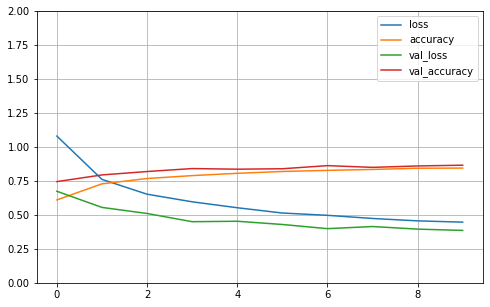

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.show()

# 批归一化在Activation之后
plot_learning_curves(history) 

In [ ]:
# 批归一化放在Activation之前
plot_learning_curves(history)